In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [4]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


In [5]:
df = df[df['mo'].isin([1,2,3,12])] #  somente meses do verão DEZ a MAR
print len(df)
df.sample(3)

3206856


,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
7662364,397,SÃO CARLOS,859.0,-21.980353,-47.883927,A711,São Carlos,SP,2011-03-20 20:00:00,2011-03-20,...,24.8,18.1,23.3,17.6,71.0,71.0,66.0,2.7,154.0,8.9
4044817,347,MOCAMBINHO,454.0,-15.085958,-44.016036,A539,Porteirinha,MG,2013-01-23 17:00:00,2013-01-23,...,28.7,21.1,27.7,19.9,63.0,66.0,61.0,1.9,94.0,4.5
526200,308,ALEGRE,129.0,-20.750412,-41.488852,A617,Alegre,ES,2009-02-04 00:00:00,2009-02-04,...,26.2,22.5,25.0,21.6,86.0,86.0,77.0,0.9,191.0,2.2


In [7]:
df = df.sort_values(['wsid', 'mdct'])
df = df.reset_index(drop=True)

In [8]:
df = df[(df['lat'].between(-20.5,-19.0, inclusive=True)) & 
        (df['lon'].between(-44.5,-43.0, inclusive=True))] 

In [9]:
df.sample(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
54650,363,IBIRITÈ (ROLA MOÇA),1199.0,-20.031457,-44.011249,A555,Ibirité,MG,2009-03-05 02:00:00,2009-03-05,...,23.4,17.5,22.5,17.1,70.0,73.0,68.0,2.1,0.0,3.0
81403,370,BELO HORIZONTE - CERCADINHO,1200.0,-19.980034,-43.958651,F501,Belo Horizonte,MG,2015-12-23 19:00:00,2015-12-23,...,27.8,15.4,26.5,13.8,48.0,49.0,44.0,5.0,97.0,9.1
47044,343,FLORESTAL,754.0,-19.885398,-44.416883,A535,Florestal,MG,2014-12-21 04:00:00,2014-12-21,...,22.1,21.0,21.6,20.5,94.0,94.0,93.0,0.2,324.0,2.0
76591,370,BELO HORIZONTE - CERCADINHO,1200.0,-19.980034,-43.958651,F501,Belo Horizonte,MG,2014-02-03 07:00:00,2014-02-03,...,19.1,14.8,18.5,13.3,77.0,78.0,70.0,6.6,96.0,9.8


# Pré-processamento

<h3>Dados ausentes</h3>

In [10]:
missing_values_count = (df.isnull().sum()/len(df))*100

In [11]:
missing_values_count[missing_values_count > 0.1]

prcp    86.761195
gbrd    41.876731
wdsp    12.057195
gust     5.879404
dtype: float64

<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [12]:
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [13]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [14]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)

In [15]:
missing_values_count = (df.isnull().sum()/len(df))*100
miss = missing_values_count[missing_values_count > 0]
miss

Series([], dtype: float64)

<p>Alguns campos estão com pouquissimos valores nulos.</p>

In [16]:
DES = ['wsid','wsnm','elvt','lat','lon','inme','city','prov','mdct','date','yr','mo','da','hr']

In [17]:
V = [x for x in df.columns if x not in DES]
#df[V].describe().T

<p><b>PRONTO! Dados recuperados!</b> Agora vamos a etapa de limpeza</p>

<h3>Limpeza dos dados</h3>

In [22]:
backup_df = df.copy

<p>Alguns campos podem ser nulos</p>

In [23]:
cols = list(df.columns)

COLS_BE_NULL = ['prcp','wdsp','gust'] + DES
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdct']

In [24]:
df[V].describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,83784.0,0.343089,2.046260,0.0,0.0,0.0,0.0,78.4
stp,83784.0,894.517334,110.223345,0.0,883.3,916.6,925.7,935.7
smax,83784.0,894.711599,110.471505,0.0,883.5,916.8,926.0,935.8
smin,83784.0,894.223229,110.410145,0.0,883.0,916.3,925.4,935.7
temp,83784.0,22.192565,4.509744,0.0,19.6,21.7,25.0,36.3
dewp,83784.0,16.739437,2.824655,0.0,15.7,17.1,18.4,23.5
tmax,83784.0,22.871639,4.757092,0.0,20.1,22.3,26.0,37.1
dmax,83784.0,17.322818,2.861175,0.0,16.3,17.7,18.9,24.1
tmin,83784.0,21.551041,4.260199,0.0,19.3,21.1,24.1,34.5
dmin,83784.0,16.185735,2.843179,-2.2,15.1,16.6,17.9,22.6


In [25]:
df[cols] = df[cols].replace({0.0:np.nan})

In [26]:
print len(df)
df  = df.dropna()
print len(df)

83784
80148


<p>Verificando os mínimos e máximos por região.</p>

In [28]:
print x[V].describe().T

        count        mean        std    min    25%    50%    75%    max
prcp  80148.0    0.344595   2.054451    0.0    0.0    0.0    0.0   78.4
stp   80148.0  908.432228  19.787321  872.8  883.7  917.0  926.3  935.7
smax  80148.0  908.684077  19.800009  873.0  883.9  917.2  926.6  935.8
smin  80148.0  908.188080  19.782929  872.7  883.5  916.7  926.0  935.7
temp  80148.0   22.559571   3.661378   12.6   19.8   21.8   25.1   36.3
dewp  80148.0   16.989345   1.988470    5.5   15.7   17.1   18.4   23.5
tmax  80148.0   23.249764   3.905134   12.7   20.2   22.4   26.2   37.1
dmax  80148.0   17.583978   1.959501    6.7   16.3   17.7   19.0   24.1
tmin  80148.0   21.909932   3.400696   12.5   19.4   21.2   24.2   34.5
dmin  80148.0   16.428833   2.075802    4.2   15.2   16.6   17.9   22.6
hmdy  80148.0   73.169848  16.856114   20.0   61.0   75.0   88.0   99.0
hmax  80148.0   76.248016  15.583952   23.0   65.0   79.0   90.0   99.0
hmin  80148.0   69.962370  17.870629   13.0   56.0   72.0   86.0

<p>Algumas regras:</p>
<ul>
   <li>Max > Min: para temperatura, humidade, pressão e ponto de orvalho</li>
   <li>Mínima para região é possivel?</li>
   <li>Máxima para região é possivel?</li>
</ul>

<p>Vamos a temperatura máxima e mínima</p>

In [29]:
x = df[(df['tmin'] > df['tmax'])]
print ('tmin>tmax',x)
x = df[(df['hmin'] > df['hmax'])]
print ('hmin>hmax',x)
x = df[(df['smin'] > df['smax'])]
print ('smin>smax',x)
x = df[(df['dmin'] > df['dmax'])]
print ('dmin>dmax',x)

('tmin>tmax', Empty DataFrame
Columns: [wsid, wsnm, elvt, lat, lon, inme, city, prov, mdct, date, yr, mo, da, hr, prcp, stp, smax, smin, temp, dewp, tmax, dmax, tmin, dmin, hmdy, hmax, hmin, wdsp, wdct, gust]
Index: []

[0 rows x 30 columns])
('hmin>hmax', Empty DataFrame
Columns: [wsid, wsnm, elvt, lat, lon, inme, city, prov, mdct, date, yr, mo, da, hr, prcp, stp, smax, smin, temp, dewp, tmax, dmax, tmin, dmin, hmdy, hmax, hmin, wdsp, wdct, gust]
Index: []

[0 rows x 30 columns])
('smin>smax', Empty DataFrame
Columns: [wsid, wsnm, elvt, lat, lon, inme, city, prov, mdct, date, yr, mo, da, hr, prcp, stp, smax, smin, temp, dewp, tmax, dmax, tmin, dmin, hmdy, hmax, hmin, wdsp, wdct, gust]
Index: []

[0 rows x 30 columns])
('dmin>dmax', Empty DataFrame
Columns: [wsid, wsnm, elvt, lat, lon, inme, city, prov, mdct, date, yr, mo, da, hr, prcp, stp, smax, smin, temp, dewp, tmax, dmax, tmin, dmin, hmdy, hmax, hmin, wdsp, wdct, gust]
Index: []

[0 rows x 30 columns])


<h4>Outliers</h4>

<p>Usando boxplot para verificar se existem outliers</p> 

In [30]:
sns.set_style("whitegrid")

<p>Pressão atmosférica</p>

In [31]:
sns.set(font_scale=2) 
def bp(var):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    #sns.boxplot(x='prov',y=var, data=df, ax=ax)
    ax = sns.distplot(df[var])
    ax2 = ax.twinx()
    sns.boxplot(x=df[var], ax=ax2)
    ax2.set(ylim=(-.5, 10))
    ax.set_title('Com outliers: ' + var)
def bp_sem(var):
    q = df[var].quantile(0.99)
    x_filt = df[df[var] < q]
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    ax = sns.distplot(x_filt[var])    
    ax.set_title('Sem outliers: ' + var)

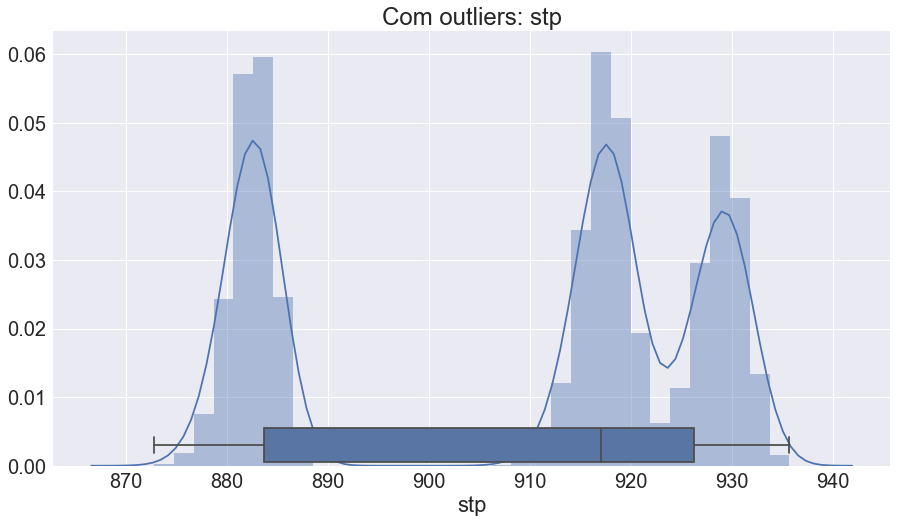

In [32]:
bp('stp')

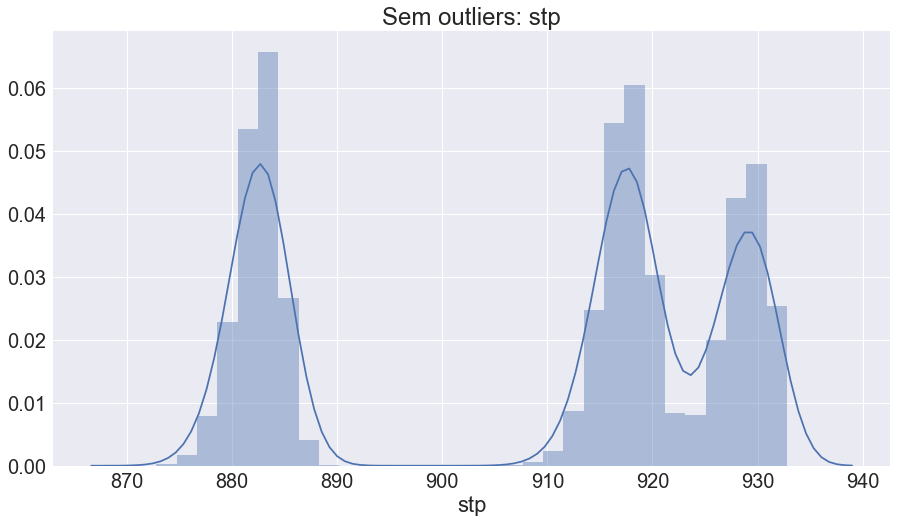

In [33]:
bp_sem('stp')

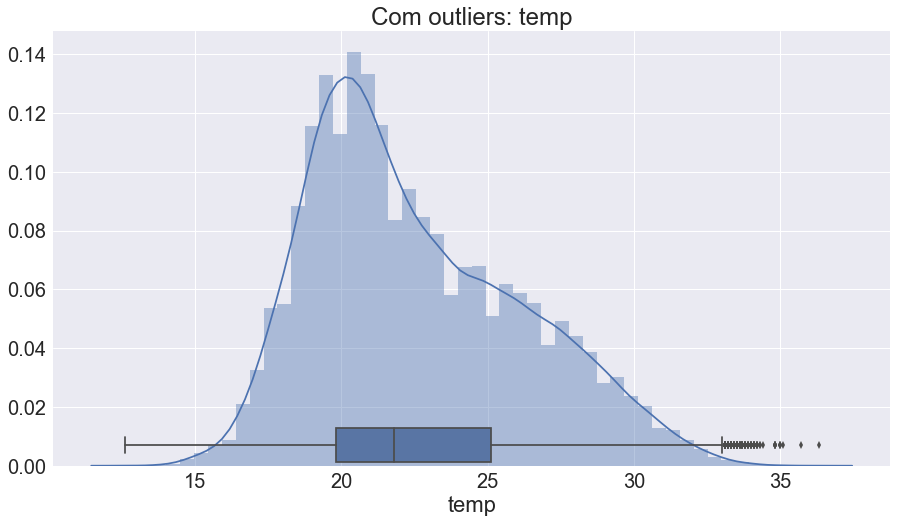

In [34]:
bp('temp')

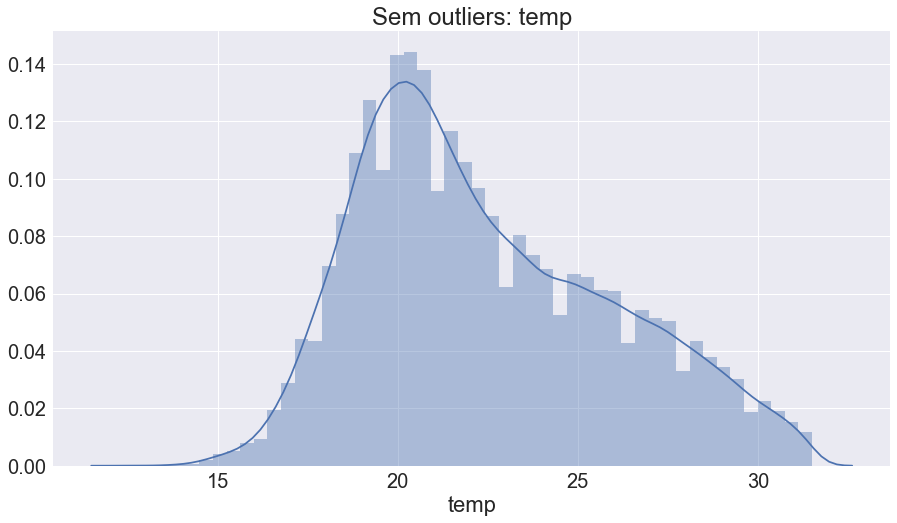

In [35]:
bp_sem('temp')

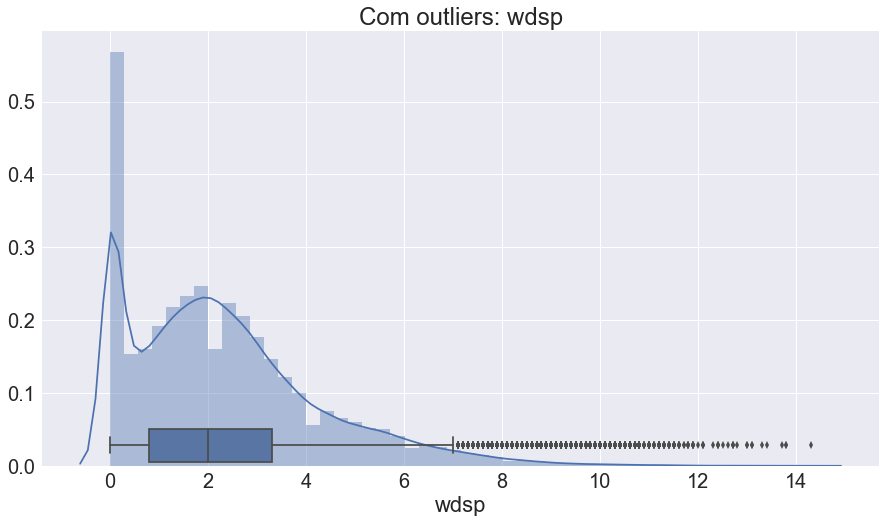

In [36]:
bp('wdsp')

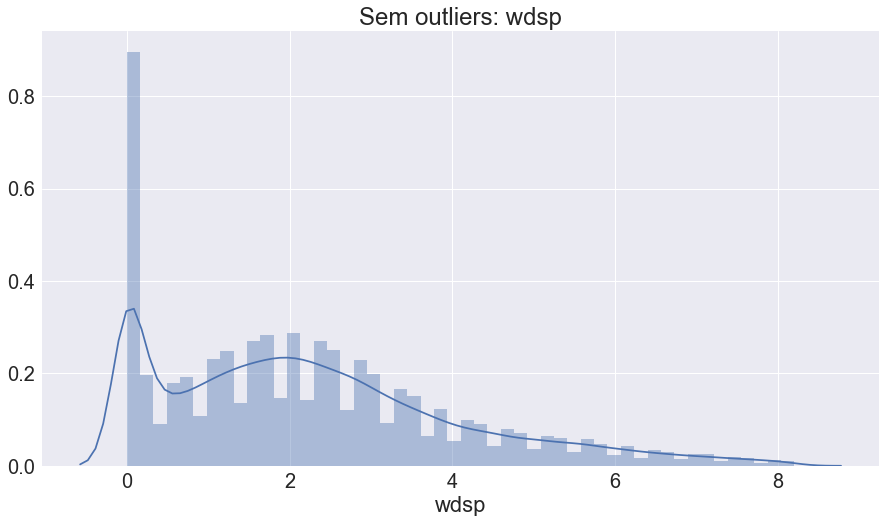

In [37]:
bp_sem('wdsp')

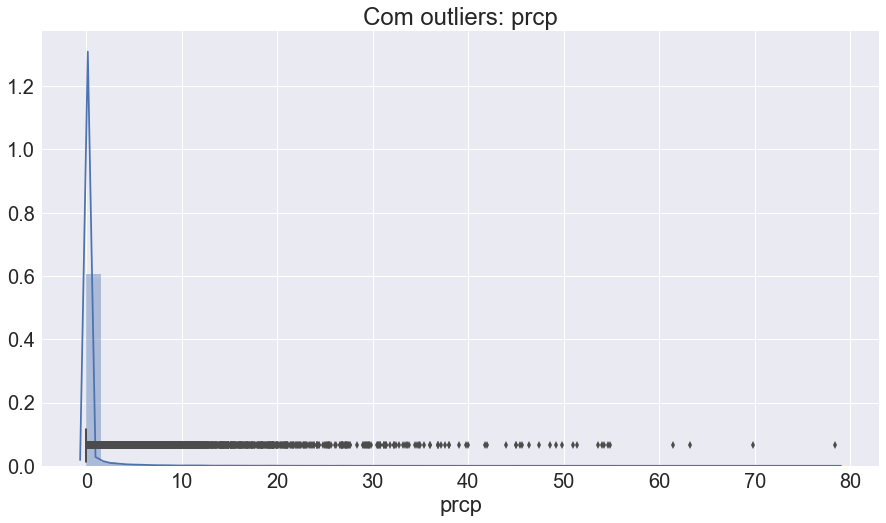

In [38]:
bp('prcp')

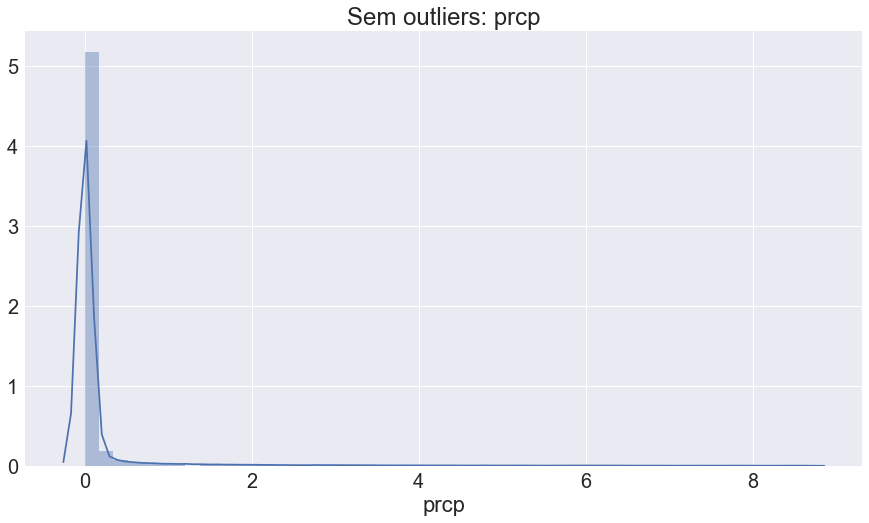

In [39]:
bp_sem('prcp')

<h3>Derivando novas variáveis (Feature engineering)</h3>

<p>Recuperando o backup do dataframe antes da limpeza dos nulos, pois preciso derivar as freatures primeiro.
Assim, após a derivá-las, irei apagar os que não pode ser nulo. Esta etapa teve que ser feita de novo, por este motivo</p> 

In [40]:
dfm = backup_df() 

In [41]:
len(dfm)

83784

In [42]:
CLEAN = ['wsnm','inme','city','prov','date']
REMOVE = ['yr', 'mo', 'da', 'hr']
#REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.sample(5)  

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
30466,343,754.0,-19.885398,-44.416883,2009-01-26 10:00:00,0.0,930.5,930.6,930.0,19.8,...,19.8,18.3,18.8,17.3,91.0,91.0,91.0,0.0,158.0,0.0
14571,329,854.0,-19.883945,-43.969397,2011-12-02 03:00:00,0.0,915.9,916.5,915.9,19.7,...,19.8,18.6,19.7,18.5,93.0,93.0,93.0,0.0,351.0,1.1
82075,370,1200.0,-19.980034,-43.958651,2016-01-20 19:00:00,0.0,876.2,876.7,876.1,20.3,...,23.1,18.3,20.2,16.7,82.0,83.0,72.0,7.2,95.0,10.8
31777,343,754.0,-19.885398,-44.416883,2009-03-22 01:00:00,0.0,928.5,928.6,928.1,20.7,...,21.7,19.2,20.7,18.6,88.0,88.0,85.0,0.0,142.0,1.1
4975,329,854.0,-19.883945,-43.969397,2008-02-25 07:00:00,11.2,915.9,916.0,915.3,18.6,...,19.6,19.0,18.5,17.9,97.0,97.0,96.0,1.6,345.0,5.2


In [43]:
ws = dfm['wsid'].groupby(dfm['wsid']).count()
ws = list(ws.keys())
print ws

[329, 343, 363, 370]


In [44]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    
    if not lag:
        return df
    
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
  
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
        
    return df

In [45]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

dfr = df_derived_by_shift(dfm,6,NON_DER)

In [46]:
dfr.head(4)

var = []
cld = list(dfr.columns)
for x in cld:
    if len(x.split('_')) >= 2:
        var.append((x.split('_')[0], x.split('_')[1]))

In [47]:
cols = {}
for v,i in var:
    x = '{}_{}'.format(v, i)
    if int(i) not in cols:
        cols[int(i)] = [x]
    else:
        cols[int(i)].append(x)
#print cols

In [65]:
xxx = dfr.copy()

In [67]:
# Inicializando
xxx['prcp_acum_6'] = 99.0
xxx['prcp_plus_1'] = 99.0

In [68]:
for w in ws:
    
    size = xxx.loc[xxx['wsid'].isin([w])].iloc[:]['prcp'].count()
    
    pos_prcp = xxx.columns.get_loc('prcp')
    
    pos_acum_6 = xxx.columns.get_loc('prcp_acum_6')
    pos_plus_1 = xxx.columns.get_loc('prcp_plus_1')
    
    for i in range(0,size):
        idx = xxx.loc[xxx['wsid'].isin([w])].index
        xxx.loc[xxx.loc[idx,'prcp_acum_6'].index[i],'prcp_acum_6'] = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+6,pos_prcp].sum()
        if i+1 < size:
            xxx.loc[xxx.loc[idx,'prcp_plus_1'].index[i],'prcp_plus_1'] = xxx.loc[xxx['wsid'].isin([w])].iloc[i+1,pos_prcp]
        else:
            xxx.loc[xxx.loc[idx,'prcp_plus_1'].index[i],'prcp_plus_1'] = 99.99

In [88]:
dfr = xxx 

In [89]:
dfr.sample(3)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmax_5,dmax_6,prcp_1,prcp_2,prcp_3,prcp_4,prcp_5,prcp_6,prcp_acum_6,prcp_plus_1
28081,329,854.0,-19.883945,-43.969397,2016-02-18 01:00:00,0.0,919.5,919.5,919.0,26.7,...,16.4,17.6,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
41361,343,754.0,-19.885398,-44.416883,2012-12-26 09:00:00,0.0,929.9,930.0,929.1,18.7,...,18.3,18.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29860,343,754.0,-19.885398,-44.416883,2009-01-01 04:00:00,0.0,928.7,929.2,928.6,19.5,...,19.1,19.4,0.0,0.0,0.4,15.6,5.4,19.2,1.0,0.0


In [90]:
dfr.columns

Index([u'wsid', u'elvt', u'lat', u'lon', u'mdct', u'prcp', u'stp', u'smax',
       u'smin', u'temp',
       ...
       u'dmax_5', u'dmax_6', u'prcp_1', u'prcp_2', u'prcp_3', u'prcp_4',
       u'prcp_5', u'prcp_6', u'prcp_acum_6', u'prcp_plus_1'],
      dtype='object', length=125)

In [91]:
dfm = dfr

In [92]:
list(dfm.columns)

['wsid',
 'elvt',
 'lat',
 'lon',
 'mdct',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdsp',
 'wdct',
 'gust',
 'wdct_1',
 'wdct_2',
 'wdct_3',
 'wdct_4',
 'wdct_5',
 'wdct_6',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'hmin_1',
 'hmin_2',
 'hmin_3',
 'hmin_4',
 'hmin_5',
 'hmin_6',
 'gust_1',
 'gust_2',
 'gust_3',
 'gust_4',
 'gust_5',
 'gust_6',
 'tmax_1',
 'tmax_2',
 'tmax_3',
 'tmax_4',
 'tmax_5',
 'tmax_6',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'hmdy_1',
 'hmdy_2',
 'hmdy_3',
 'hmdy_4',
 'hmdy_5',
 'hmdy_6',
 'mdct_1',
 'mdct_2',
 'mdct_3',
 'mdct_4',
 'mdct_5',
 'mdct_6',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 'dewp_5',
 'dewp_6',
 'wdsp_1',
 'wdsp_2',
 'wdsp_3',
 'wdsp_4',
 'wdsp_5',
 'wdsp_6',
 'stp_1',
 'stp_2',
 '

In [93]:
len(dfm)

83784

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [94]:
cols = list(df.columns)

COLS_BE_NULL = ['prcp','wdsp','gust'] + DES + ['temp']
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdct']

In [95]:
dfm[cols] = dfm[cols].replace({0.0:np.nan}) 

In [96]:
print len(dfm)
dfm  = dfm.dropna()
print len(dfm)

83784
79430


In [97]:
dfm = dfm.reset_index(drop=True)

In [98]:
dfm.head(5)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmax_5,dmax_6,prcp_1,prcp_2,prcp_3,prcp_4,prcp_5,prcp_6,prcp_acum_6,prcp_plus_1
0,329,854.0,-19.883945,-43.969397,2006-12-01 06:00:00,0.0,913.5,913.8,913.4,20.8,...,20.6,20.5,0.6,12.4,1.8,0.4,0.0,0.0,0.0,0.0
1,329,854.0,-19.883945,-43.969397,2006-12-01 07:00:00,0.0,913.4,913.6,913.4,20.2,...,20.6,20.6,0.0,0.6,12.4,1.8,0.4,0.0,0.0,0.0
2,329,854.0,-19.883945,-43.969397,2006-12-01 08:00:00,0.0,914.2,914.2,913.4,20.1,...,20.5,20.6,0.0,0.0,0.6,12.4,1.8,0.4,0.2,0.0
3,329,854.0,-19.883945,-43.969397,2006-12-01 09:00:00,0.0,915.0,915.0,914.2,20.7,...,20.4,20.5,0.0,0.0,0.0,0.6,12.4,1.8,0.2,0.0
4,329,854.0,-19.883945,-43.969397,2006-12-01 10:00:00,0.0,915.7,915.7,915.0,21.3,...,20.1,20.4,0.0,0.0,0.0,0.0,0.6,12.4,0.6,0.0


In [99]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79430 entries, 0 to 79429
Columns: 125 entries, wsid to prcp_plus_1
dtypes: float64(117), int64(1), object(7)
memory usage: 75.8+ MB


In [100]:
dfm = dfm.drop('wsid',1)
dfm = dfm.drop('mdct',1)

In [101]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdsp',
 'wdct',
 'gust',
 'wdct_1',
 'wdct_2',
 'wdct_3',
 'wdct_4',
 'wdct_5',
 'wdct_6',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'hmin_1',
 'hmin_2',
 'hmin_3',
 'hmin_4',
 'hmin_5',
 'hmin_6',
 'gust_1',
 'gust_2',
 'gust_3',
 'gust_4',
 'gust_5',
 'gust_6',
 'tmax_1',
 'tmax_2',
 'tmax_3',
 'tmax_4',
 'tmax_5',
 'tmax_6',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'hmdy_1',
 'hmdy_2',
 'hmdy_3',
 'hmdy_4',
 'hmdy_5',
 'hmdy_6',
 'mdct_1',
 'mdct_2',
 'mdct_3',
 'mdct_4',
 'mdct_5',
 'mdct_6',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 'dewp_5',
 'dewp_6',
 'wdsp_1',
 'wdsp_2',
 'wdsp_3',
 'wdsp_4',
 'wdsp_5',
 'wdsp_6',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',


In [102]:
REMOVE = [u'mdct',u'mdct_1', u'mdct_2', u'mdct_3', u'mdct_4', u'mdct_5', u'mdct_6']
for v in REMOVE:
    if v in list(dfm.columns):
        dfm = dfm.drop(v,1)

In [103]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdsp',
 'wdct',
 'gust',
 'wdct_1',
 'wdct_2',
 'wdct_3',
 'wdct_4',
 'wdct_5',
 'wdct_6',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'hmin_1',
 'hmin_2',
 'hmin_3',
 'hmin_4',
 'hmin_5',
 'hmin_6',
 'gust_1',
 'gust_2',
 'gust_3',
 'gust_4',
 'gust_5',
 'gust_6',
 'tmax_1',
 'tmax_2',
 'tmax_3',
 'tmax_4',
 'tmax_5',
 'tmax_6',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'hmdy_1',
 'hmdy_2',
 'hmdy_3',
 'hmdy_4',
 'hmdy_5',
 'hmdy_6',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 'dewp_5',
 'dewp_6',
 'wdsp_1',
 'wdsp_2',
 'wdsp_3',
 'wdsp_4',
 'wdsp_5',
 'wdsp_6',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',
 'stp_5',
 'stp_6',
 'smin_1',
 'smin_2',
 'smin_3',
 'smin_4',
 '

In [104]:
REMOVE = [u'prcp',u'prcp_1', u'prcp_2', u'prcp_3', u'prcp_4', u'prcp_5', u'prcp_6']
for v in REMOVE:
    if v in list(dfm.columns):
        dfm = dfm.drop(v,1)

In [105]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdsp',
 'wdct',
 'gust',
 'wdct_1',
 'wdct_2',
 'wdct_3',
 'wdct_4',
 'wdct_5',
 'wdct_6',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'hmin_1',
 'hmin_2',
 'hmin_3',
 'hmin_4',
 'hmin_5',
 'hmin_6',
 'gust_1',
 'gust_2',
 'gust_3',
 'gust_4',
 'gust_5',
 'gust_6',
 'tmax_1',
 'tmax_2',
 'tmax_3',
 'tmax_4',
 'tmax_5',
 'tmax_6',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'hmdy_1',
 'hmdy_2',
 'hmdy_3',
 'hmdy_4',
 'hmdy_5',
 'hmdy_6',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 'dewp_5',
 'dewp_6',
 'wdsp_1',
 'wdsp_2',
 'wdsp_3',
 'wdsp_4',
 'wdsp_5',
 'wdsp_6',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',
 'stp_5',
 'stp_6',
 'smin_1',
 'smin_2',
 'smin_3',
 'smin_4',
 'smin_5',


In [106]:
#como esta rede é especifica para a BH, vamos remover elvt, lat, lon
REMOVE = ['elvt','lat', 'lon']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [107]:
dfm

,stp,smax,smin,temp,dewp,tmax,dmax,tmin,dmin,hmdy,...,dmin_5,dmin_6,dmax_1,dmax_2,dmax_3,dmax_4,dmax_5,dmax_6,prcp_acum_6,prcp_plus_1
0,913.5,913.8,913.4,20.8,19.0,21.0,19.6,20.1,19.0,90.0,...,20.5,20.2,20.1,20.4,20.5,20.6,20.6,20.5,0.0,0.00
1,913.4,913.6,913.4,20.2,19.3,20.8,19.7,20.2,19.1,95.0,...,20.3,20.5,19.6,20.1,20.4,20.5,20.6,20.6,0.0,0.00
2,914.2,914.2,913.4,20.1,19.4,20.6,19.4,19.9,19.1,96.0,...,20.3,20.3,19.7,19.6,20.1,20.4,20.5,20.6,0.2,0.00
3,915.0,915.0,914.2,20.7,19.4,20.7,19.5,19.9,19.2,92.0,...,20.1,20.3,19.4,19.7,19.6,20.1,20.4,20.5,0.2,0.00
4,915.7,915.7,915.0,21.3,19.3,21.3,19.3,20.6,18.8,88.0,...,19.5,20.1,19.5,19.4,19.7,19.6,20.1,20.4,0.6,0.00
5,916.2,916.3,915.7,21.9,19.1,21.9,19.6,21.2,18.7,84.0,...,19.0,19.5,19.3,19.5,19.4,19.7,19.6,20.1,0.6,0.00
6,916.7,916.7,916.2,22.9,18.9,23.0,19.5,21.9,18.4,78.0,...,19.1,19.0,19.6,19.3,19.5,19.4,19.7,19.6,0.6,0.20
7,916.9,916.9,916.7,22.2,19.0,23.2,19.5,22.2,18.4,82.0,...,19.1,19.1,19.5,19.6,19.3,19.5,19.4,19.7,0.6,0.00
8,916.9,917.0,916.9,22.9,18.7,23.0,19.7,21.8,18.4,77.0,...,19.2,19.1,19.5,19.5,19.6,19.3,19.5,19.4,0.4,0.40
9,916.9,917.1,916.9,22.6,18.4,23.1,19.9,22.1,18.4,78.0,...,18.8,19.2,19.7,19.5,19.5,19.6,19.3,19.5,0.4,0.00


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [109]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [110]:
target = 'prcp_plus_1'

In [112]:
X = dfm[[col for col in dfm.columns]]
y = dfm[target]

<p>Separando o conjunto de treinamento e validação (metade dos 10% separados para validação)</p>

In [114]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.1, random_state=12) 
print len(X_train)
print len(X_tmp)

71487
7943


<p>Separando o conjunto de testes</p>

In [115]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.2)

In [116]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   71487, Training features   107
Validation instances 1589, Validation features 107
Testing instances    6354, Testing features    107


In [117]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
#activation_fn = tf.sigmoid
batch_size = 1000
up = int(len(X_train)/batch_size)

In [118]:
Z = X.copy()
Z.pop(target)
feature_cols = [tf.feature_column.numeric_column(col) for col in Z.columns] 

In [119]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols
                                      ,hidden_units=[st_units,sd_units]
                                      #,activation_fn=activation_fn
                                      ,model_dir='/tmp/tf_model_04')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x111da5090>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tf_model_04', '_save_summary_steps': 100}


In [120]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):      
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [125]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(return_indices=True)

In [126]:
def balancear(_X, _y):
    
    def f(x):
        if x['prcp_plus_1'] == 0.0: 
            return 0
        else:        
            return 1
        
    #Balancear considerando apenas com chuva e sem chuva.    
    _X['type'] = _X.apply(f,axis=1) 
    
    _X_resampled, _y_resampled, idx_resampled = under.fit_sample(_X, _X['type'])
    
    _X = pd.DataFrame(_X_resampled, columns = _X.columns)
    _y = pd.DataFrame(_y_resampled, columns =['type'])
    
    _y = _X['prcp_plus_1']
    
    _X = _X.drop('type',1)
    _X = _X.drop('prcp_plus_1',1)
    
    return _X,_y

In [127]:
evaluations = []  
STEPS = 500  

for i in range(1, up):
    
    A, b = balancear(X_train.copy(), y_train.copy())
    
    print ('treinando agora...')
    
    regressor.train(input_fn=wx_input_fn(A ,b), steps=STEPS)
    
    evaluations.append(
        regressor.evaluate(input_fn=wx_input_fn(X_val
                                                ,y_val
                                                ,num_epochs=1
                                                ,shuffle=False)))

treinando agora...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_04/model.ckpt-19001


InvalidArgumentError: tensor_name = dnn/hiddenlayer_1/bias; shape in shape_and_slice spec [107] does not match the shape stored in checkpoint: [115]
	 [[Node: save/RestoreV2_4 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_4/tensor_names, save/RestoreV2_4/shape_and_slices)]]

Caused by op u'save/RestoreV2_4', defined at:
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-127-f583f7e0be4e>", line 13, in <module>
    , steps=STEPS)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/estimator/estimator.py", line 302, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/estimator/estimator.py", line 780, in _train_model
    log_step_count_steps=self._config.log_step_count_steps) as mon_sess:
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 368, in MonitoredTrainingSession
    stop_grace_period_secs=stop_grace_period_secs)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 673, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 493, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 851, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 856, in _create_session
    return self._sess_creator.create_session()
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 554, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 419, in create_session
    self._scaffold.finalize()
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 212, in finalize
    self._saver.build()
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 745, in _build_internal
    restore_sequentially, reshape)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 470, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 427, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 267, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1021, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): tensor_name = dnn/hiddenlayer_1/bias; shape in shape_and_slice spec [107] does not match the shape stored in checkpoint: [115]
	 [[Node: save/RestoreV2_4 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_4/tensor_names, save/RestoreV2_4/shape_and_slices)]]


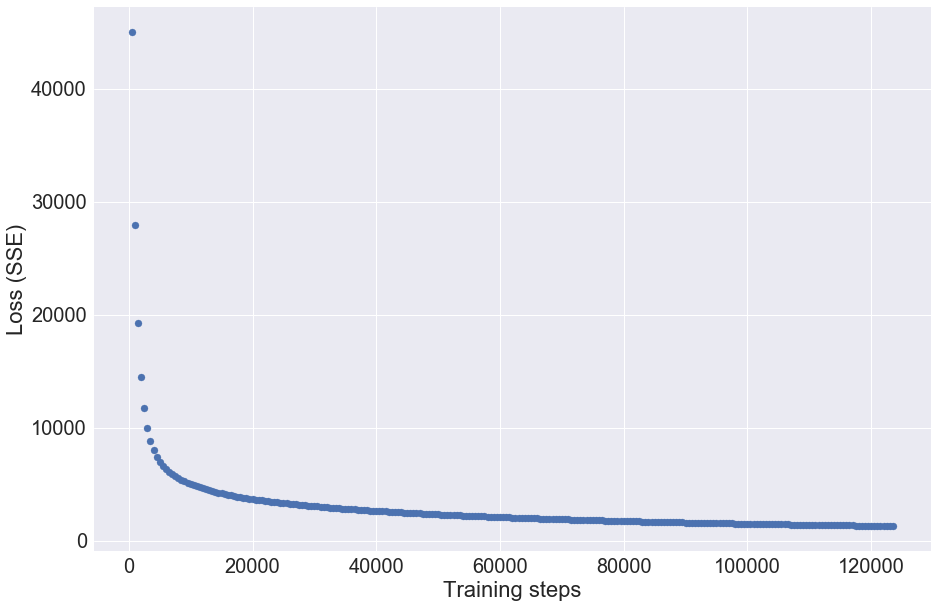

In [201]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [202]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Restoring parameters from /tmp/tf_model_03/model.ckpt-123500


In [203]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f " % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: 0.93
The Mean Absolute Error: 0.87 
The Median Absolute Error: 0.70 


In [204]:
predictions

array([30.336958, 23.706419, 32.090603, ..., 22.952717, 24.697342,
       30.114582], dtype=float32)

In [205]:
predictions.size

222104

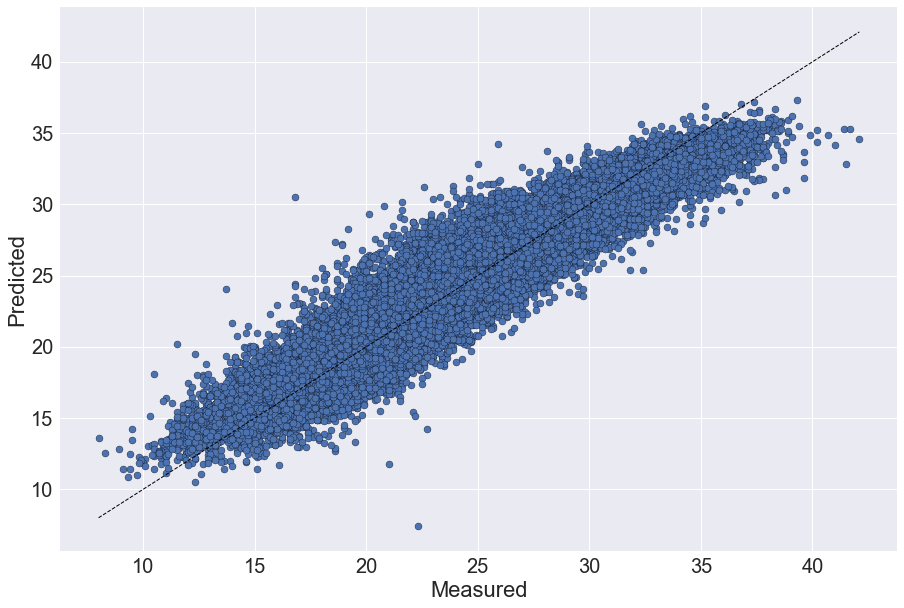

In [206]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()